# Multi-label классификация по ключевым словам


## Импорты

In [29]:
import os
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [30]:
ROOT_DIR = os.path.split(os.getcwd())[0]
DATA_DIR = os.path.join(ROOT_DIR, 'data', 'processed')
DATA_DIR


'/home/margarita/github/hse-nlp-2022/data/processed'

from google.colab import drive
drive.mount('/content/drive')

## Предварительная работа с данными
Загрузим предобработанный датасет в датафрейм `pandas`. Из абстрактов были предварительно удалены знаки препинания, сам текст переведен в lower case.

In [31]:
fname = os.path.join(DATA_DIR, 'top5.csv')
data = pd.read_csv(fname, sep=',', quotechar='"', encoding='utf-8', engine='python')
data.head()

,journal,DOI,abstract,keywords
0,ieee-proc,10.1109/JPROC.2013.2257631,the wireless sensor network wsn technology spa...,['Control systems']
1,ieee-proc,10.1109/JPROC.2010.2064151,owing in part to complementary metaloxidesemic...,['Logic gates']
2,ieee-proc,10.1109/JPROC.2010.2065211,semiconductor nanowires have attracted conside...,['Silicon']
3,ieee-proc,10.1109/JPROC.2010.2063411,power density has grown to be the dominant cha...,['Logic gates']
4,ieee-proc,10.1109/JPROC.2010.2070470,steep subthreshold swing transistors based on ...,['Logic gates']


В качестве текстовых фичей мы используем абстракты `abstract`, в качестве лейблов - клчевые слова `keywords`, указанные в соответствующих статьях.


In [32]:
print(f"Количество статей: {len(data)}")

Количество статей: 17162


Приведем лейблы к более удобному формату:

In [33]:
data["keywords"] = data["keywords"].apply(
    lambda x: literal_eval(x)
)
data["keywords"].values[:5]

array([list(['Control systems']), list(['Logic gates']),
       list(['Silicon']), list(['Logic gates']), list(['Logic gates'])],
      dtype=object)

Разобьем данные на тестовую, валидационную и тренировочную выборки.

In [34]:
test_split = 0.1

train_df, test_df = train_test_split(
    data,
    test_size=test_split,
)

val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Статей в тренировочной выборке: {len(train_df)}")
print(f"Статей в валидационной выборке: {len(val_df)}")
print(f"Статей в тестовой выборке: {len(test_df)}")

Статей в тренировочной выборке: 15445
Статей в валидационной выборке: 858
Статей в тестовой выборке: 859


/home/margarita/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Создание словаря и one-hot encoding

Используя слой `StringLookUp`, получим словарь из ключевых слов и закодируем их.

In [35]:
terms = tf.ragged.constant(train_df["keywords"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Словарь:\n")
print(vocab)
print()
example = tf.ragged.constant(vocab)[0]
print("Пример закодированного вектора:\n")
print(lookup(example).numpy())

Словарь:

['[UNK]', 'Control systems', 'Logic gates', 'Equations', 'Silicon', 'Linear systems']

Пример закодированного вектора:

[1. 0. 0. 0. 0. 0.]


## Сбор итогового датасета

Для дальнейшего обучения будет полезно посмотреть на характеристики абстрактов.

In [36]:
train_df["abstract"].apply(lambda x: len(x.split(" "))).describe()

count    15445.000000
mean       111.826157
std         55.927742
min          2.000000
25%         68.000000
50%        105.000000
75%        148.000000
max        390.000000
Name: abstract, dtype: float64

Видим, что у половины статей длина абстракта не превышает 105 слов. Таким образом, в дальнейшем разумно брать примерно такую максимальную длину текста для обучения модели.

Соберем датасет, состоящий из абстрактов и one-hot векторов, представляющих ключевые слова.

In [21]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["keywords"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["abstract"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)


In [37]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

Выведем некоторые примеры из этого датасета:

In [38]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'the design of a residual generator for fault detection and isolation fdi in nonlinear systems which are affine in the control signals and in the failure modes is studied first the problem statement used for linear systems is extended and a set of sufficient conditions for the existence of a solution is given next circumstances under which highgain observers for uniformly observable systems can be used in the synthesis of the residual generator are provided'
Label(s): ['Control systems' 'Linear systems']
 
Abstract: b'this note shows that beyond the expected basic results on supervisor existence and synthesis the temporal logic systems analysis for the invariance control of an arbitrary past formula p yields new insights into supremal control of temporal safety these insights come in the form of equivalent temporal characterizations one characterization allows a naturallanguage interpretation which provides a very good intuitive feel of the supremal controllability concept a

## Векторизация текста
Посмотрим, насколько большим будет словарь, полученный из абстрактов.


In [ ]:
vocabulary = set()
train_df["abstract"].str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print("Размер словаря:", vocabulary_size)


Для того, чтобы модель могла работать с нашими текстами, нужно конвертировать информацию в числа. Для этого воспользуемся готовым слоем `TextVectorization`. Сначала этот слой разобьет тест на биграммы, потом выдаст представления, используя `TF-IDF`.

In [41]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)


## Обучаемая модель
В качестве модели используем достаточно простую сеть, состоящую из пары полносвязных слоев с ReLU в качестве функции активации.


In [50]:

def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model


Epoch 1/20
250/250 [==============================] - 10s 36ms/step - loss: 0.1523 - categorical_accuracy: 0.3243 - val_loss: 0.1303 - val_categorical_accuracy: 0.3305
Epoch 2/20
250/250 [==============================] - 9s 34ms/step - loss: 0.0477 - categorical_accuracy: 0.5337 - val_loss: 0.1542 - val_categorical_accuracy: 0.3108
Epoch 3/20
250/250 [==============================] - 9s 35ms/step - loss: 0.0126 - categorical_accuracy: 0.5746 - val_loss: 0.2108 - val_categorical_accuracy: 0.2995
Epoch 4/20
250/250 [==============================] - 9s 35ms/step - loss: 0.0052 - categorical_accuracy: 0.5914 - val_loss: 0.2454 - val_categorical_accuracy: 0.3069
Epoch 5/20
250/250 [==============================] - 9s 36ms/step - loss: 0.0039 - categorical_accuracy: 0.6015 - val_loss: 0.2692 - val_categorical_accuracy: 0.3209
Epoch 6/20
250/250 [==============================] - 9s 35ms/step - loss: 0.0042 - categorical_accuracy: 0.6029 - val_loss: 0.2870 - val_categorical_accuracy: 0.29

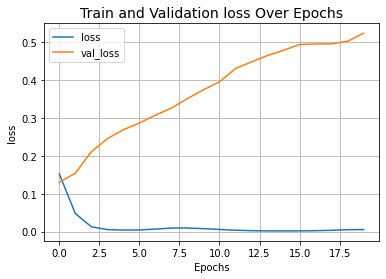

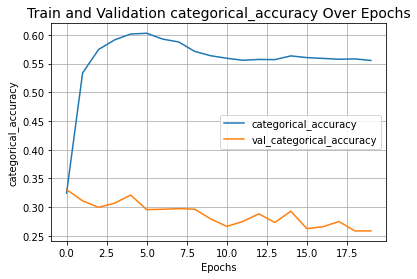

In [51]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

Проверим точность на тестовой выборке:

In [53]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

14/14 [==============================] - 0s 27ms/step - loss: 0.5267 - categorical_accuracy: 0.2696
Categorical accuracy on the test set: 26.96%.
